In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

pd.set_option('display.max_columns', None)

In [2]:
# Wczytanie wszystkich plików CSV do jednego DataFrame
folder_path = Path('../data/raw')
all_files = folder_path.glob('*.csv')

df_all = pd.concat(
    [
        pd.read_csv(f, delimiter=',', decimal=',', low_memory=False)
        for f in all_files
    ],
    ignore_index=True
)

In [3]:
# Czyszczenie: break-in-time-series i brakujące wartości
if 'OBS_FLAG' in df_all.columns:
    df_all = df_all[df_all['OBS_FLAG'] != 'b']
df_all = df_all.dropna(subset=['OBS_VALUE'])

In [4]:
# Wybór najnowszego roku dla każdego miasta i wskaźnika
df_all = df_all.sort_values(
    ['Geopolitical entity (declaring)', 'Urban audit indicator', 'TIME_PERIOD'],
    ascending=[True, True, False]
)
df_latest = df_all.drop_duplicates(
    subset=['Geopolitical entity (declaring)', 'Urban audit indicator'],
    keep='first'
)

In [5]:
# Pivot do szerokiego formatu (1 wiersz = 1 miasto, kolumny = wskaźniki)
df_wide = df_latest.pivot(
    index='Geopolitical entity (declaring)',
    columns='Urban audit indicator',
    values='OBS_VALUE'
).reset_index()

In [6]:
# Czytelne nazwy kolumn
rename_map = {
    'Population on the 1st of January, total': 'Population',
    'Age dependency ratio (population aged 0-19 and 65 and more to population aged 20-64)': 'Age_dependency_ratio',
    'Young-age dependency ratio (population aged 0-19 to population 20-64 years)': 'Young_dependency_ratio',
    'Old age dependency ratio (population 65 and over to population 20 to 64 years)': 'Old_dependency_ratio',
    'Median population age': 'Median_age',
    'Foreigners as a proportion of population': 'Share_foreigners',
    'Infant mortality rate (per 1000 live births)': 'Infant_mortality_rate',
    'Crude birth rate (per 1000 inhabitants)': 'Crude_birth_rate',
    'Number of deaths per year under 65 due to diseases of the circulatory or respiratory systems':
        'Deaths_under_65_circulatory_respiratory',
    'Crude death rate (per 1000 inhabitants)': 'Crude_death_rate',
    'Share of persons at risk of poverty or social exclusion -%': 'Share_poverty_risk',
    'Average area of living accommodation - mÂ˛/person': 'Avg_living_area_m2_per_person',
    'Average annual rent for housing per mÂ˛ - EUR': 'Avg_annual_rent_per_m2',
    'Average price for buying an apartment  per m2 - EUR': 'Avg_apartment_price_per_m2',
    'Share of students in higher education in the total population (per 1000 persons)': 'Share_students_higher_edu',
    'Share of early leavers from education and training, total -%': 'Share_early_leavers',
    'Number of available beds per 1000 residents': 'Beds_per_1000',
    'Total nights spent in tourist accommodation establishments per resident population': 'Tourist_nights_per_resident',
    'Unemployment rate': 'Unemployment_rate',
    'Share of journeys to work by public transport (rail, metro, bus, tram) -%': 'Share_public_transport',
    'Share of journeys to work by car or motor cycle -%': 'Share_car_motorcycle',
    'Average time of journey to work - minutes': 'Avg_journey_minutes',
    'Number of registered cars per 1000 population': 'Cars_per_1000',
    'People killed in road accidents per 10000 pop.': 'Road_deaths_per_10000',
    'Total number of hours of sunshine per day': 'Sunshine_hours_per_day',
    'Average temperature of warmest month - degrees': 'Temp_warmest_month',
    'Average temperature of coldest month - degrees': 'Temp_coldest_month',
    'Rainfall - litre/mÂ˛': 'Rainfall_l_per_m2',
    'Annual average concentration of NO2 (Âµg/mÂł)': 'NO2_avg_conc',
    'Municipal waste generated (domestic and commercial), total - 1000 t': 'Municipal_waste_1000t'
}

df_wide = df_wide.rename(columns=rename_map)

In [7]:
# Lista wszystkich kolumn oprócz nazwy miasta
numeric_cols = df_wide.columns.drop('Geopolitical entity (declaring)')

# Konwersja na liczby
df_wide[numeric_cols] = df_wide[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Teraz nazwy miast zostają, a reszta jest numeryczna
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 31 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Geopolitical entity (declaring)                   926 non-null    object 
 1   Age_dependency_ratio                              835 non-null    float64
 2   Annual average concentration of NO2 (µg/m³)       1 non-null      float64
 3   Average annual rent for housing per m² - EUR      371 non-null    float64
 4   Average area of living accommodation - m²/person  606 non-null    float64
 5   Avg_apartment_price_per_m2                        261 non-null    float64
 6   Temp_coldest_month                                8 non-null      float64
 7   Temp_warmest_month                                8 non-null      float64
 8   Avg_journey_minutes                               149 non-null    float64
 9   Crude_birth_rate     

In [8]:
df_wide.describe().T

,count,mean,std,min,25%,50%,75%,max
Urban audit indicator,,,,,,,,
Age_dependency_ratio,835.0,66.218443,8.854913,41.20,60.9000,65.900,72.0000,130.90
Annual average concentration of NO2 (µg/m³),1.0,35.000000,NaN,35.00,35.0000,35.000,35.0000,35.00
Average annual rent for housing per m² - EUR,371.0,54.276011,53.804471,4.91,9.0750,39.290,84.0000,256.80
Average area of living accommodation - m²/person,606.0,37.385429,10.413019,14.10,29.0000,39.130,46.0000,56.50
Avg_apartment_price_per_m2,261.0,2275.468008,1122.187785,333.03,1559.1400,2022.000,2647.0000,9074.00
Temp_coldest_month,8.0,7.450000,2.712932,4.20,5.7250,6.850,9.4000,12.20
Temp_warmest_month,8.0,28.162500,0.921082,27.00,27.4250,28.050,29.0500,29.30
Avg_journey_minutes,149.0,24.397651,4.094527,17.50,21.9000,23.700,26.0000,39.90
Crude_birth_rate,851.0,9.033173,2.778824,0.01,7.2300,8.980,10.5650,42.29


In [9]:
# usunięcie kolumn z dużą liczbą braków
df_wide = df_wide.loc[:, df_wide.count() >= 100]

In [10]:
# Poprawianie zmiennych
## po analizie irracjonalnych przypadków wychodzi na to, że prawdopodobnie wprowadzono wartości zgonów na 1 mln zamiast na 1 tys. urodzeń
df_wide['Infant_mortality_rate'] = df_wide['Infant_mortality_rate'].apply(lambda x: x/1000 if x >1000 else x)

# Deaths absolute → per 100k mieszkańców
if 'Deaths_under_65_circulatory_respiratory' in df_wide.columns and 'Population' in df_wide.columns:
    df_wide['Deaths_under_65_circ_resp_per_100k'] = (
        df_wide['Deaths_under_65_circulatory_respiratory'] / df_wide['Population'] * 100_000
    )

In [11]:
df_wide.describe().T

,count,mean,std,min,25%,50%,75%,max
Urban audit indicator,,,,,,,,
Age_dependency_ratio,835.0,66.218443,8.854913,41.20,60.900000,65.900000,72.00000,1.309000e+02
Average annual rent for housing per m² - EUR,371.0,54.276011,53.804471,4.91,9.075000,39.290000,84.00000,2.568000e+02
Average area of living accommodation - m²/person,606.0,37.385429,10.413019,14.10,29.000000,39.130000,46.00000,5.650000e+01
Avg_apartment_price_per_m2,261.0,2275.468008,1122.187785,333.03,1559.140000,2022.000000,2647.00000,9.074000e+03
Avg_journey_minutes,149.0,24.397651,4.094527,17.50,21.900000,23.700000,26.00000,3.990000e+01
Crude_birth_rate,851.0,9.033173,2.778824,0.01,7.230000,8.980000,10.56500,4.229000e+01
Crude_death_rate,876.0,10.448767,2.948422,0.38,8.540000,10.415000,12.27000,1.961000e+01
Share_foreigners,799.0,10.409512,8.191818,0.00,4.100000,9.100000,14.85000,5.820000e+01
Infant_mortality_rate,840.0,3.696149,2.319722,0.00,2.180000,3.475000,4.78250,1.528000e+01


In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
numeric_cols = df_wide.select_dtypes(include=['number']).columns.tolist()
X = df_wide[numeric_cols].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

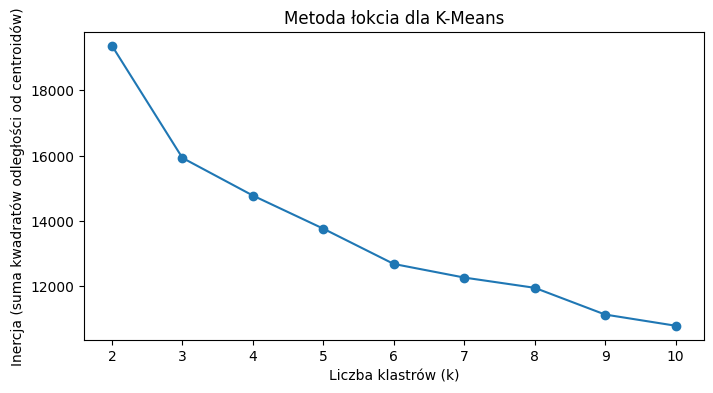

In [14]:
inertia = []
K_range = range(2, 11)  # testujemy od 2 do 10 klastrów

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Liczba klastrów (k)")
plt.ylabel("Inercja (suma kwadratów odległości od centroidów)")
plt.title("Metoda łokcia dla K-Means")
plt.show()


In [15]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df_wide['Cluster'] = kmeans.fit_predict(X_scaled)


Cluster
1    370
3    225
0    147
2     91
5     79
4     14
Name: count, dtype: int64
Urban audit indicator  Age_dependency_ratio  \
Cluster                                       
0                                 63.734694   
1                                 65.067751   
2                                 46.750000   
3                                 66.050222   
4                                 63.015385   
5                                 77.713924   

Urban audit indicator  Average annual rent for housing per m² - EUR  \
Cluster                                                               
0                                                         32.282877   
1                                                         49.776477   
2                                                               NaN   
3                                                         80.174427   
4                                                         89.986667   
5                                     

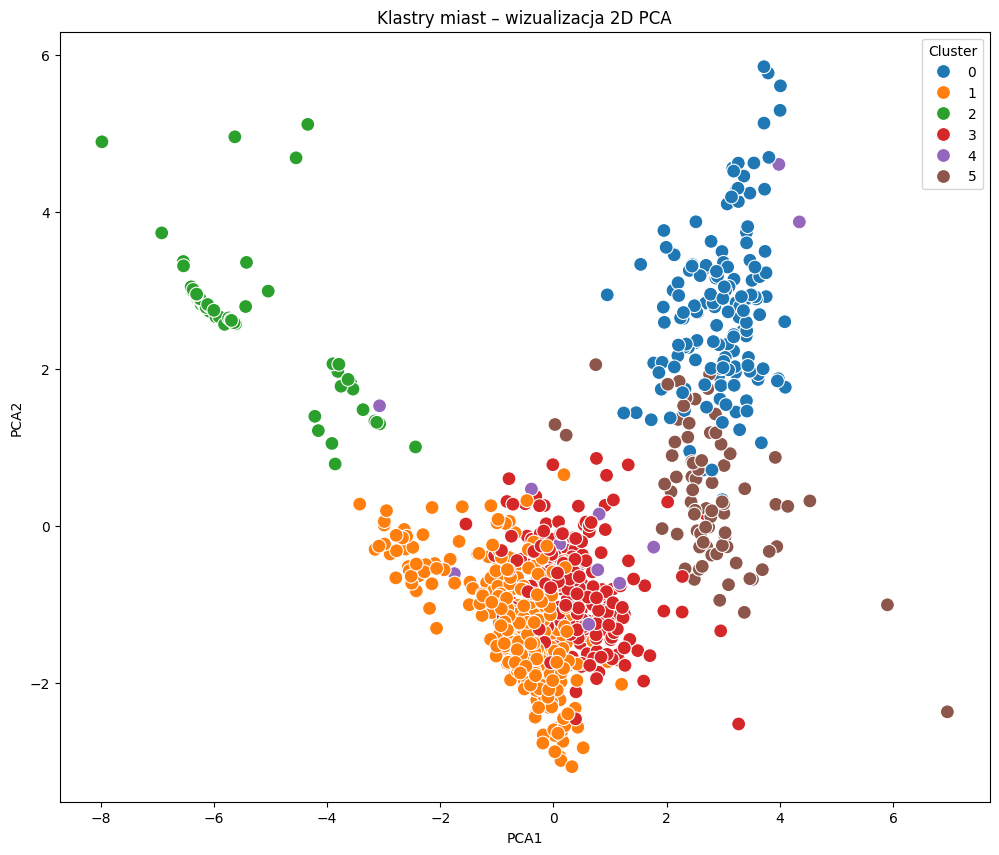

In [16]:
# Ile miast w każdym klastrze
print(df_wide['Cluster'].value_counts())

# Średnie wartości wskaźników w klastrach
cluster_summary = df_wide.groupby('Cluster')[numeric_cols].mean()
print(cluster_summary)

# Wizualizacja w dwóch wymiarach (PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_wide['PCA1'] = X_pca[:,0]
df_wide['PCA2'] = X_pca[:,1]

plt.figure(figsize=(12,10))
sns.scatterplot(data=df_wide, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title("Klastry miast – wizualizacja 2D PCA")
plt.show()


In [17]:
df_wide['Cluster'].value_counts()


Cluster
1    370
3    225
0    147
2     91
5     79
4     14
Name: count, dtype: int64

In [18]:
cluster_summary = df_wide.groupby('Cluster')[numeric_cols].mean()
print(cluster_summary.T)  # transpozycja, żeby łatwiej czytać


Cluster                                                       0  \
Urban audit indicator                                             
Age_dependency_ratio                                  63.734694   
Average annual rent for housing per m² - EUR          32.282877   
Average area of living accommodation - m²/person      46.818912   
Avg_apartment_price_per_m2                          2139.586066   
Avg_journey_minutes                                   24.296690   
Crude_birth_rate                                       9.167823   
Crude_death_rate                                      11.662381   
Share_foreigners                                      18.570748   
Infant_mortality_rate                                  3.237664   
Median_age                                            42.976871   
Municipal_waste_1000t                                111.856869   
Beds_per_1000                                         25.347143   
Deaths_under_65_circulatory_respiratory               79.46206

In [19]:
# Pokazanie wszystkich miast i ich klastrów
df_wide[['Geopolitical entity (declaring)', 'Cluster']].sort_values('Cluster')
 

Urban audit indicator,Geopolitical entity (declaring),Cluster
895,Wuppertal,0
896,Würzburg,0
42,Aschaffenburg,0
594,Paderborn,0
605,Passau,0
...,...,...
539,Nantes (greater city),5
551,Nice (greater city),5
628,Poitiers (greater city),5
31,Annecy (greater city),5


In [20]:
# Wybieramy tylko unikalne wiersze z kodem miasta i nazwą
city_map = df_all[['Geopolitical entity (declaring)', 'cities']].drop_duplicates()

# Dołączamy do df_wide po kodzie miasta
df_wide = df_wide.merge(city_map,
                        on='Geopolitical entity (declaring)',
                        how='left')

# Sprawdzamy efekt
df_wide[['Geopolitical entity (declaring)', 'cities']].head(10)
df_wide[df_wide['Cluster'] == 1]

,Geopolitical entity (declaring),Age_dependency_ratio,Average annual rent for housing per m² - EUR,Average area of living accommodation - m²/person,Avg_apartment_price_per_m2,Avg_journey_minutes,Crude_birth_rate,Crude_death_rate,Share_foreigners,Infant_mortality_rate,Median_age,Municipal_waste_1000t,Beds_per_1000,Deaths_under_65_circulatory_respiratory,Cars_per_1000,Old_dependency_ratio,Road_deaths_per_10000,Population,Share_early_leavers,Share_car_motorcycle,Share_public_transport,Share_students_higher_edu,Tourist_nights_per_resident,Unemployment_rate,Young_dependency_ratio,Deaths_under_65_circ_resp_per_100k,Cluster,PCA1,PCA2,cities
1,'s-Hertogenbosch,63.8,NaN,NaN,NaN,NaN,9.88,9.45,6.5,1.89,40.0,651.00,NaN,46.0,546.45,29.8,0.13,160757.0,NaN,NaN,NaN,37.1,NaN,2.53,34.0,28.614617,1,-1.049899,-1.030028,NL025C
4,Aalborg,63.5,90.85,48.70,NaN,NaN,11.86,10.62,NaN,2.61,39.7,NaN,NaN,68.0,NaN,27.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,1,-0.783788,-0.400685,DK004C
5,Aberdeen,53.0,NaN,NaN,NaN,NaN,10.24,9.51,16.5,1.25,37.1,59.78,NaN,122.0,394.73,23.7,0.09,228180.0,NaN,NaN,NaN,117.9,NaN,7.16,29.2,53.466561,1,-0.966578,-0.479572,UK015C
9,Alba Iulia,48.8,NaN,17.42,NaN,NaN,8.26,7.63,NaN,3.24,NaN,NaN,16.42,52.0,NaN,21.4,NaN,74659.0,NaN,NaN,NaN,73.4,1.62,NaN,27.3,69.650009,1,-2.636915,-0.043937,RO014C
17,Alkmaar (greater city),73.0,NaN,NaN,NaN,NaN,9.44,9.39,5.5,2.81,41.0,1089.00,NaN,10.0,491.27,34.6,0.26,226692.0,NaN,NaN,NaN,30.0,NaN,3.25,38.4,4.411272,1,-0.731644,-1.271259,NL002C
18,Almelo,72.8,NaN,NaN,NaN,NaN,9.55,10.83,6.8,4.23,41.0,344.00,NaN,5.0,497.96,34.3,0.14,74317.0,NaN,NaN,NaN,30.4,NaN,4.39,38.6,6.727936,1,-0.507942,-1.471323,NL003C
19,Almere,58.8,NaN,NaN,NaN,NaN,11.28,5.62,11.6,2.35,36.0,928.00,NaN,61.0,1165.84,18.7,0.05,226500.0,NaN,NaN,NaN,34.6,1.88,4.08,40.2,26.931567,1,-0.880456,-0.784862,NL004C
21,Alphen aan den Rijn,71.6,NaN,NaN,NaN,NaN,10.33,8.29,6.2,5.05,41.0,532.00,NaN,NaN,489.80,32.8,0.27,114966.0,NaN,NaN,NaN,31.8,NaN,3.60,38.8,NaN,1,-0.671416,-1.348192,NL005C
22,Altamura,65.1,NaN,NaN,NaN,NaN,8.92,7.57,4.7,1.72,41.0,25.54,14.86,11.0,568.61,26.9,0.29,70038.0,NaN,NaN,NaN,0.0,0.55,8.46,38.2,15.705760,1,-1.050921,-1.035083,IT053C
23,Alytus,64.2,9.94,24.50,889.79,NaN,4.83,12.29,2.1,4.03,49.0,19.63,9.50,39.0,520.55,34.1,0.39,51340.0,NaN,NaN,NaN,14.2,0.64,NaN,30.1,75.964160,1,-0.390612,-1.463791,LT004C


In [22]:
# centroidy (średnie w każdej zmiennej dla klastra)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids


Urban audit indicator,Age_dependency_ratio,Average annual rent for housing per m² - EUR,Average area of living accommodation - m²/person,Avg_apartment_price_per_m2,Avg_journey_minutes,Crude_birth_rate,Crude_death_rate,Share_foreigners,Infant_mortality_rate,Median_age,Municipal_waste_1000t,Beds_per_1000,Deaths_under_65_circulatory_respiratory,Cars_per_1000,Old_dependency_ratio,Road_deaths_per_10000,Population,Share_early_leavers,Share_car_motorcycle,Share_public_transport,Share_students_higher_edu,Tourist_nights_per_resident,Unemployment_rate,Young_dependency_ratio,Deaths_under_65_circ_resp_per_100k
0,0.187772,0.238972,1.136363,0.958145,2.199091,0.238782,0.478721,1.140784,-0.136651,0.376524,-0.082505,-0.001325,-0.029701,0.152552,0.420375,-0.095906,-0.008320,1.913755,1.545726,1.562861,0.376762,0.081074,-0.101058,-0.058467,0.038661
1,0.241774,-0.229456,-0.600246,-0.391900,-0.420702,0.360380,0.321732,-0.429507,0.245594,-0.122016,-0.063835,-0.291924,0.026043,-0.172846,0.091258,-0.131911,-0.089591,-0.373895,-0.554737,-0.479221,-0.200926,-0.345281,-0.558721,0.336209,0.575817
2,-2.738563,-0.503657,-1.033544,-0.541730,-0.375641,-1.710579,-2.099848,-0.918873,-1.136605,-1.302250,0.628339,-0.404002,-0.415519,-1.041224,-2.434251,-0.379226,-0.350579,-0.373895,-0.468505,-0.407667,-0.805177,-0.477849,-0.952800,-2.485465,-1.244338
3,0.295829,0.577500,0.285051,-0.366754,-0.430785,-0.417819,0.021291,0.222384,-0.046859,0.470437,-0.080574,0.585395,-0.169056,0.509585,0.417243,0.349998,-0.060261,-0.340145,-0.554737,-0.464130,0.244566,0.484082,0.821361,0.114270,-0.293579
4,-0.055847,0.389577,0.253662,0.399362,-0.176048,0.273640,-0.005080,0.251994,-0.073332,-0.090690,0.206397,-0.056848,6.499457,-0.203997,-0.036111,-0.081699,5.822995,-0.206164,-0.354371,0.229171,0.071632,0.178230,-0.016203,-0.066002,0.086536
5,0.840135,-0.503657,1.030509,1.650402,-0.430785,0.979738,-0.038557,0.269312,0.559733,0.047126,-0.078383,0.177886,-0.258383,0.309853,0.412433,0.250747,-0.021376,-0.373895,1.904331,1.087213,0.458223,0.606414,1.565919,1.083392,-0.514642


In [23]:
# Różnica max-min między centroidami dla każdej zmiennej
importance = centroids.max() - centroids.min()
importance.sort_values(ascending=False)

Urban audit indicator
Deaths_under_65_circulatory_respiratory             6.914976
Population                                          6.173573
Age_dependency_ratio                                3.578698
Young_dependency_ratio                              3.568857
Old_dependency_ratio                                2.854626
Crude_birth_rate                                    2.690317
Avg_journey_minutes                                 2.629876
Crude_death_rate                                    2.578570
Unemployment_rate                                   2.518720
Share_car_motorcycle                                2.459069
Share_early_leavers                                 2.287650
Avg_apartment_price_per_m2                          2.192132
Average area of living accommodation - m²/person    2.169907
Share_foreigners                                    2.059657
Share_public_transport                              2.042082
Deaths_under_65_circ_resp_per_100k                  1.820155
Me

In [24]:
centroids_orig = scaler.inverse_transform(centroids)
centroids_orig = pd.DataFrame(centroids_orig, columns=X_scaled.columns)
centroids_orig


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

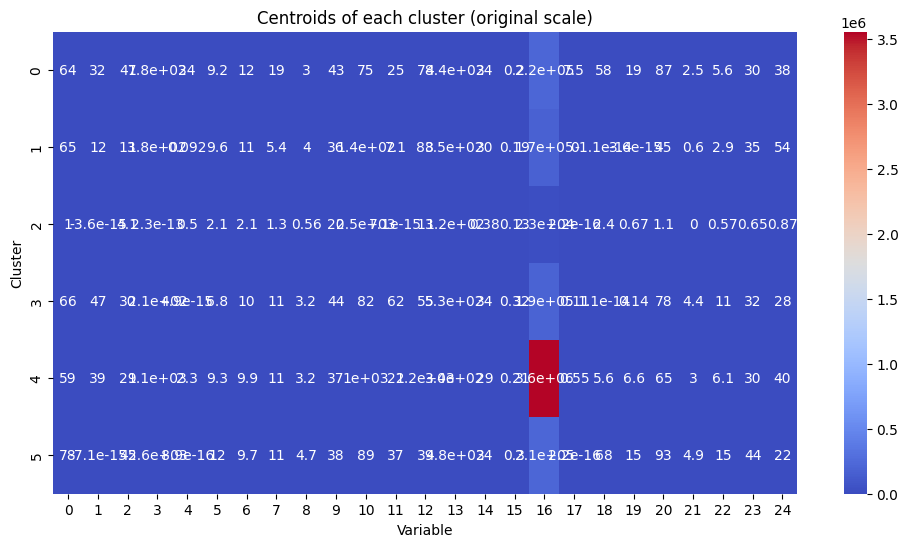

In [25]:
plt.figure(figsize=(12,6))
sns.heatmap(centroids_orig, annot=True, cmap='coolwarm')
plt.xlabel('Variable')
plt.ylabel('Cluster')
plt.title('Centroids of each cluster (original scale)')
plt.show()
